# Clustering

En este tutorial aprenderemos a trabajar técnicas de clustering. En el tutorial veremos distintos modelos:
- Basados en particiones: K-Medias, K-medoids.
- Métodos jerárquicos.
- Basados en densidad: DBSCAN
- Análisis de Componentes Princiales y Clustering
- Basados en distribuciones: GMMs



# Kmeans

En este ejemplo, vamos a generar un conjunto de muestras aleatorias. Comenzamos a generar estos datos

In [67]:
# Para KMedoids
!pip install scikit-learn-extra


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Nata\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [68]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

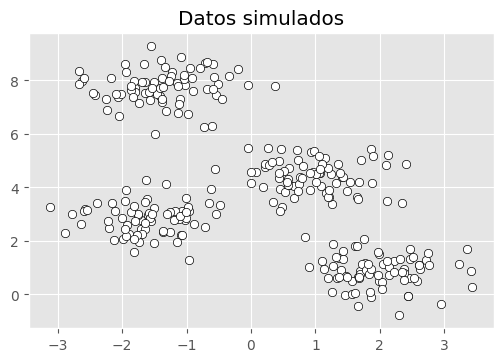

In [69]:
# Simulación de datos
# ==============================================================================
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

La implementación de `sklearn.cluster.KMeans` tiene los siguientes parámetros:
- `n_clusters`: determina el número *𝐾* de clusters que se van a generar.
- `init`: estrategia para asignar los centroides iniciales. Por defecto se emplea 'k-means++', una estrategia que trata de alejar los centroides lo máximo posible facilitando la convergencia. Sin embargo, esta estrategia puede ralentizar el proceso cuando hay muchos datos, si esto ocurre, es mejor utilizar 'random'.
- `n_init`: determina el número de veces que se va a repetir el proceso, cada vez con una asignación aleatoria inicial distinta. Es recomendable que este último valor sea alto, entre 10-25, para no obtener resultados subóptimos debido a una iniciación poco afortunada del proceso.
- `max_iter`: número máximo de iteraciones permitidas.
- `random_state`: semilla para garantizar la reproducibilidad de los resultados.

In [70]:
# Escalado de datos
# ==============================================================================
X_scaled = scale(X)

In [71]:
# Modelo
# ==============================================================================
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=42)
modelo_kmeans.fit(X=X_scaled)

KMeans(n_clusters=4, n_init=25, random_state=42)

El objeto devuelto por `KMeans()` contiene entre otros datos: la media de cada una de las variables para cada cluster (`cluster_centers_`), es decir, los centroides. Un vector indicando a qué cluster se ha asignado cada observación (`.labels_`) y la suma total de cuadrados internos de todos los clusters (`.inertia_`).

Vamos a pintar como nos quedan los clusters

In [72]:
# Clasificación con el modelo kmeans
# ==============================================================================
y_predict = modelo_kmeans.predict(X=X_scaled)

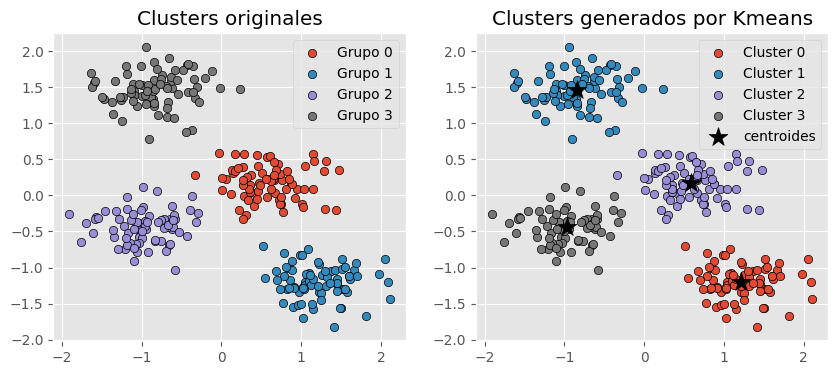

In [73]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

Podemos ver también el número de aciertos y errores. Podemos verlo como una matriz de confusión. Aquí hay que tener cuidado que Kmeans asigna un cluster cuyo número puede ser distinto. Por lo tanto, cada fila tiene que tener un número alto (aciertos) y en las demás posiciones valores bajos (errores de clasificación)

In [74]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'])

cluster,0,1,2,3
grupo_real,,,,
0,0,0,75,0
1,75,0,0,0
2,0,0,0,75
3,0,75,0,0


Vamos a ver que pasaría si en vez de decirle a KMeans que son 4 clusters, le decimos que K=2 ó K=6

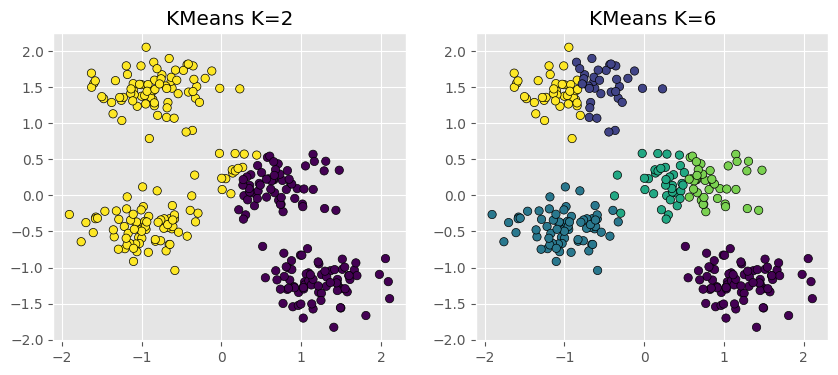

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para K = 2
# ==============================================================================
y_predict = KMeans(n_clusters=2, n_init=25, random_state=42).fit_predict(X=X_scaled)
ax[0].scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = y_predict,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[0].set_title('KMeans K=2');

# Resultados para K = 6
# ==============================================================================
y_predict = KMeans(n_clusters=6, n_init=25, random_state=42).fit_predict(X=X_scaled)
ax[1].scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = y_predict,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[1].set_title('KMeans K=6');

## Número de clusters

### Método del codo (Elbow method)
La solución al problema anterior es hacer una búsqueda de cual sería el K mejor. La idea es obtener para valor de K la suma de los cuadrados de la distancia de cada punto con el centroide al que se encuentra asignado (se obtiene de `.inertia_`). Es una medida de lo coherentes que son internamente los clusters. La idea es que si K crece el valor de `.inertia_` es menor porque cada cluster es más pequeño. Sin embargo, a partir de cierto punto, la adición de más clusters proporciona rendimientos decrecientes en términos de reducción de `.inertia_`, y la tasa de disminución se ralentiza, formando un codo en el gráfico. Ese sería el valor óptimo para seleccionar.

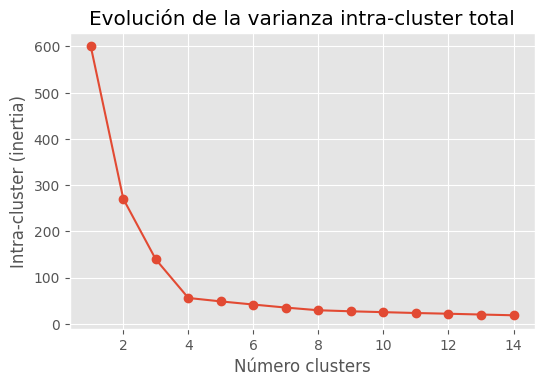

In [76]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Vemos como el valor óptimo es K=4, como ya sabíamos.

### Método Silhouette
Algunas veces, con el método Elbow es difícil determinar en número óptimo de clusters. Otra aproximación es el método Silhouette. Utiliza la distancia media intraclúster y la distancia media clúster más cercano para cada muestra. Cuanto mayor sea el valor de la puntuación, mejor será la estimación. Normalmente, las puntuaciones de silhoutte suben y luego bajan hasta alcanzar un número óptimo de clusters. Los valores se sitúan entre -1,0 y 1,0.

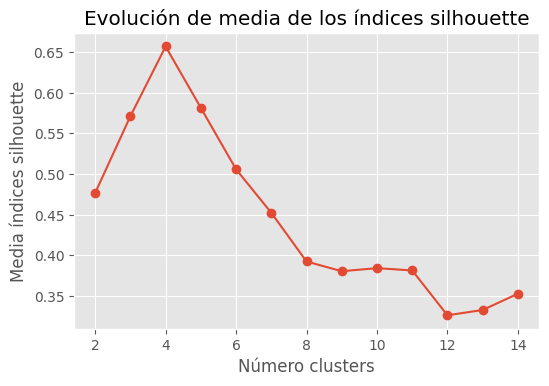

In [77]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Podemos también dibujar los gráficos de silhouette para un conjunto de clusters. Los gráficos los haremos para 2, 3, 4, 5, y 6.

Para n_clusters = 2 La media de silhouette_score es : 0.4768094347435569
Para n_clusters = 3 La media de silhouette_score es : 0.4659245814155095
Para n_clusters = 4 La media de silhouette_score es : 0.6569234398199433
Para n_clusters = 5 La media de silhouette_score es : 0.5934961058102172
Para n_clusters = 6 La media de silhouette_score es : 0.5180894552131979


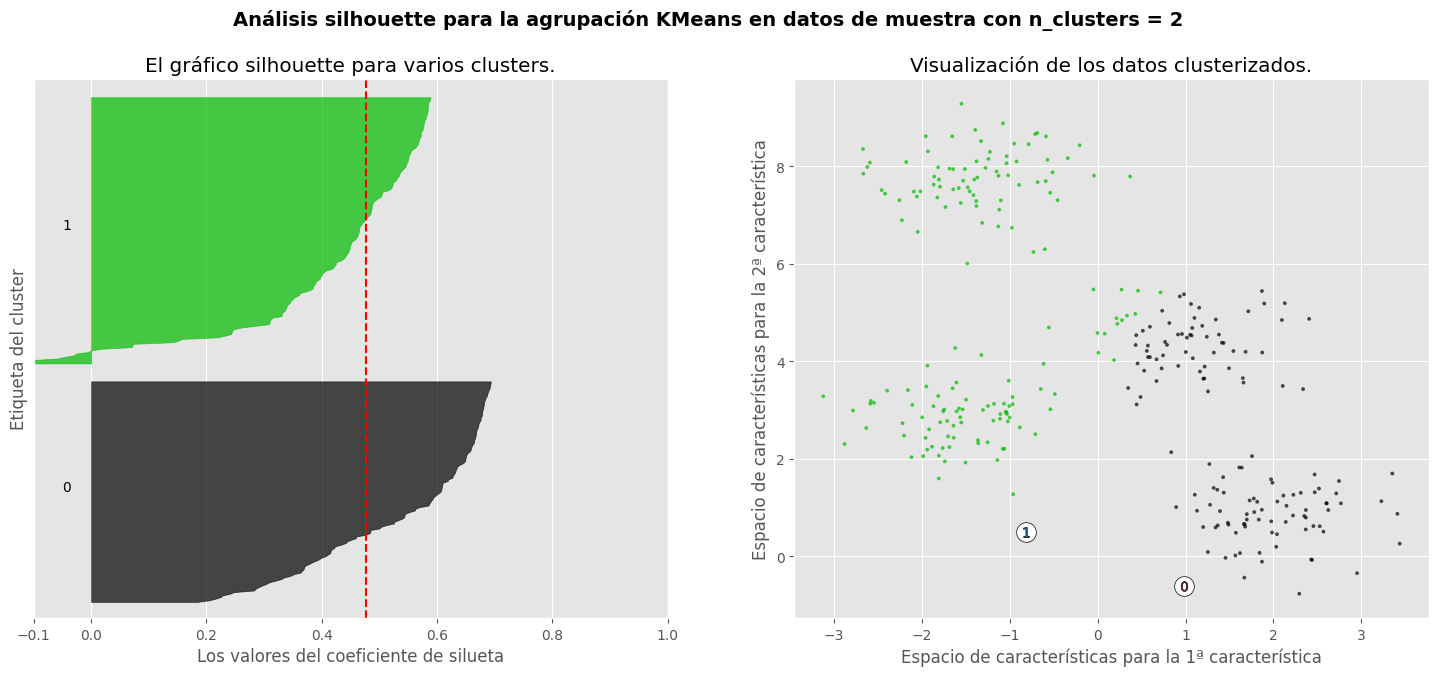

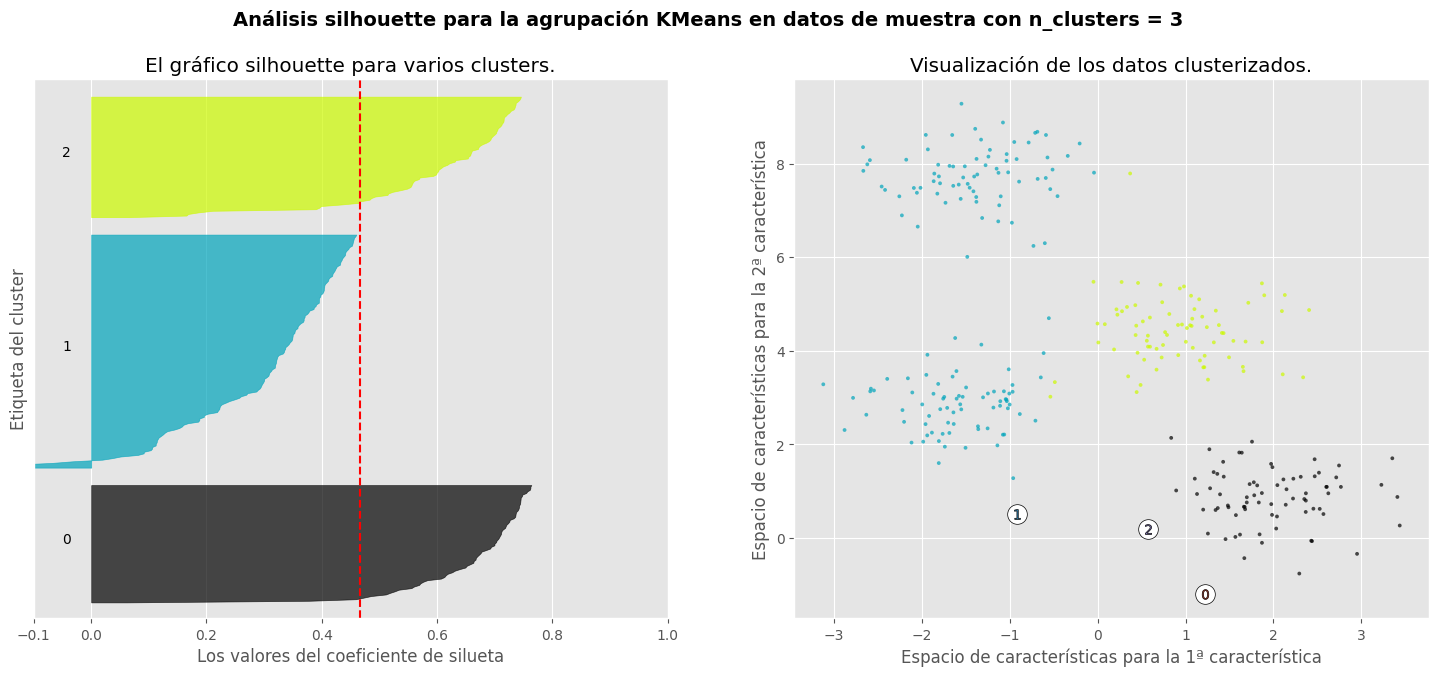

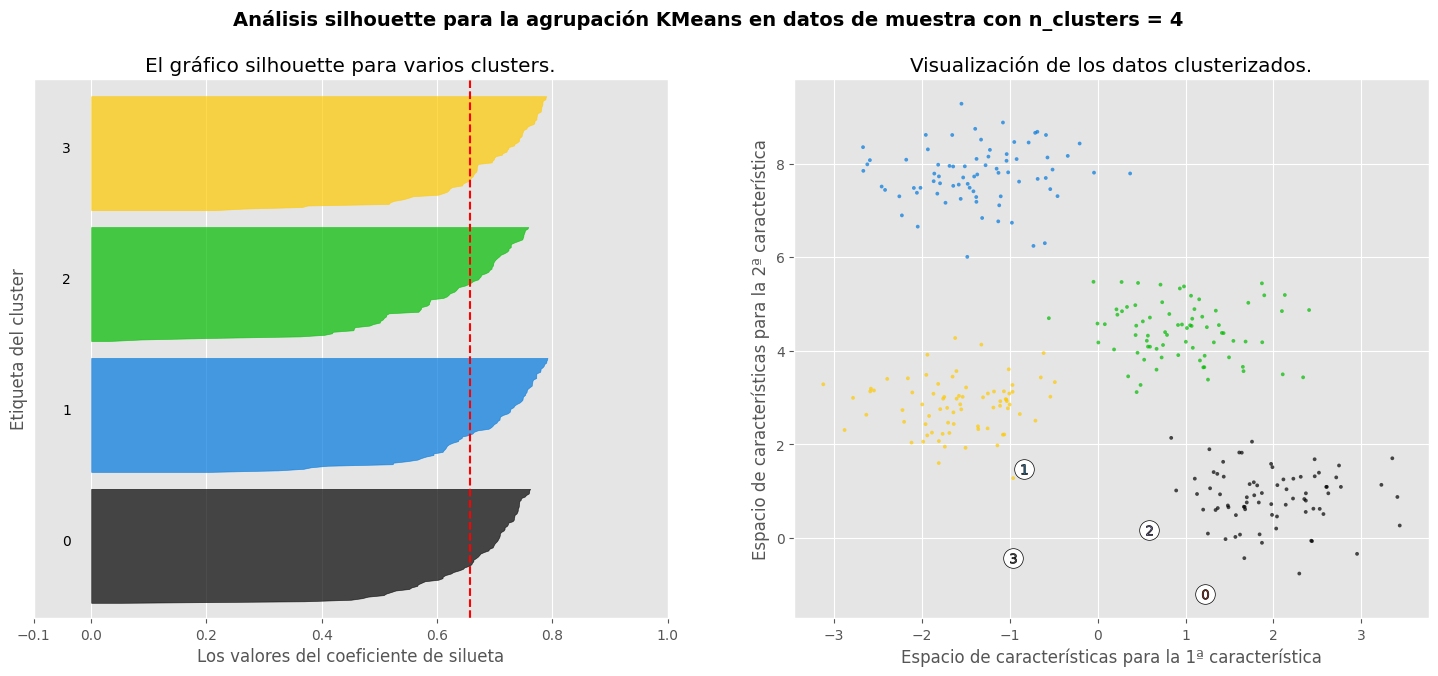

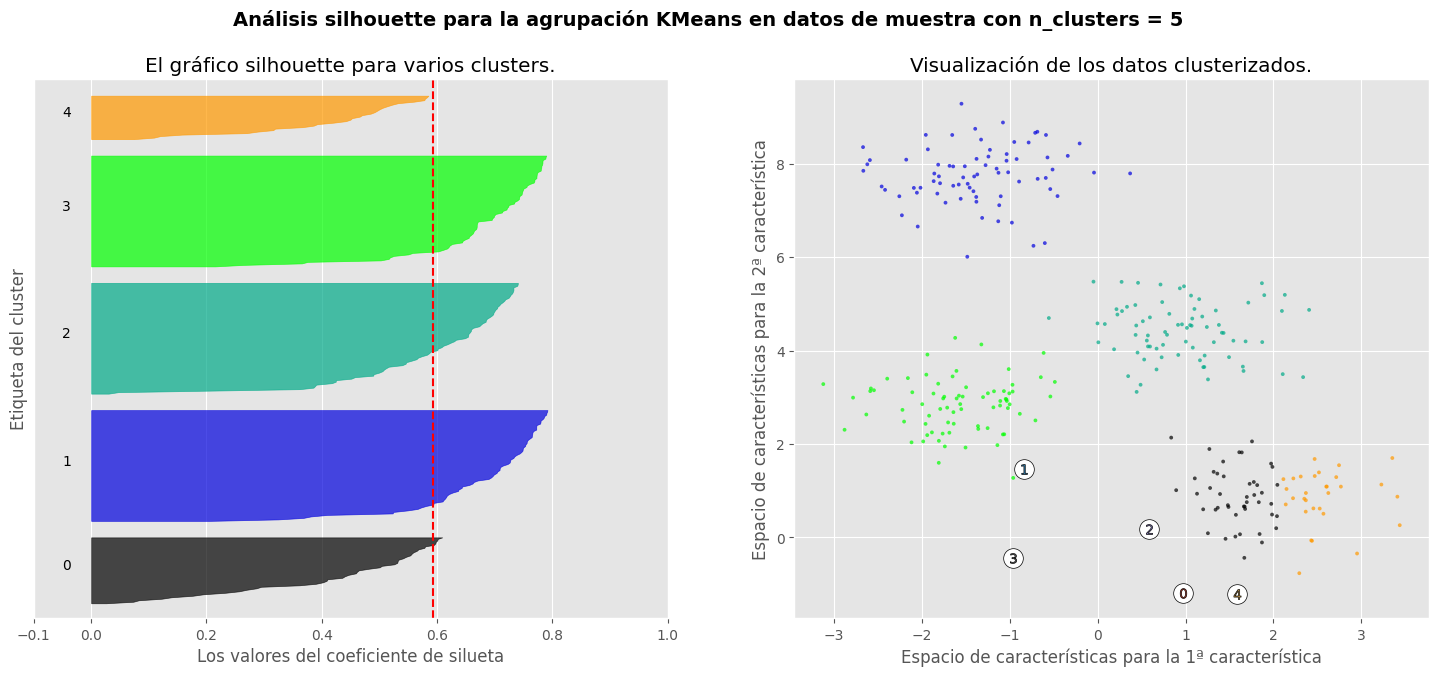

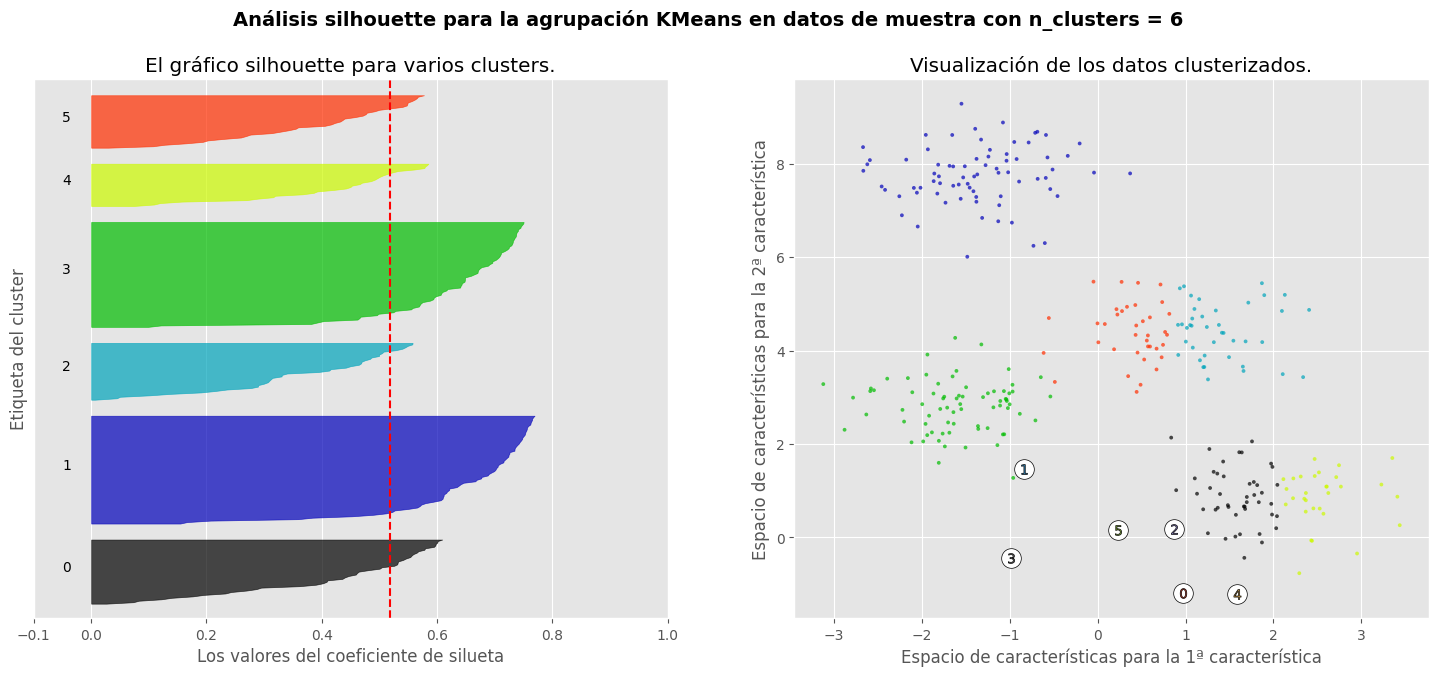

In [78]:
# Gráficos silhouette para identificar el número óptimo de clusters
# ==============================================================================

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Crear un subplot con 1 fila y dos columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # El primer subplot es el gráfico silhouette
    # El coeficiente de silhouette puede oscilar entre -1, 1 pero en este ejemplo
    # todos se encuentran dentro de [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # El (n_clusters+1)*10 sirve para insertar un espacio en blanco entre los
    # gráficos de silhouette de los clusters individuales, para delimitarlos claramente.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Inicializar el clusterer con n_clusters valor y un generador aleatorio
    # aleatorio de 42 para la reproducibilidad.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # El silhouette_score da el valor medio de todas las muestras. Esto da una
    # perspectiva de la densidad y separación de los clusters formados
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(
        "Para n_clusters =",
        n_clusters,
        "La media de silhouette_score es :",
        silhouette_avg,
    )

    # Calcular las puntuaciones de silhouette de cada muestra
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Agregar las puntuaciones de silhouette de las muestras pertenecientes al
        # cluster i, y ordénelas
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Etiquetar los gráficos de silhouette con sus números de cluster en el
        # centro.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcular el nuevo y_lower para el siguiente gráfico
        y_lower = y_upper + 10

    ax1.set_title("El gráfico silhouette para varios clusters.")
    ax1.set_xlabel("Los valores del coeficiente de silueta")
    ax1.set_ylabel("Etiqueta del cluster")

    # La línea vertical para la puntuación media de silhouette de todos los valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # El segundo plot dibuja los clusters formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Etiquetando los clusters
    centers = clusterer.cluster_centers_
    # Dibujar círculos blancos en los centros de los clusters
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualización de los datos clusterizados.")
    ax2.set_xlabel("Espacio de características para la 1ª característica")
    ax2.set_ylabel("Espacio de características para la 2ª característica")

    plt.suptitle(
        "Análisis silhouette para la agrupación KMeans en datos de muestra con n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

En este ejemplo se utiliza el análisis de silhouette para elegir un valor óptimo para n_clusters. El gráfico de silhouette muestra que los valores n_clusters de 3, 5 y 6 son una mala elección para los datos dados debido a la presencia de clusters con puntuaciones de silueta por debajo de la media y también debido a las amplias fluctuaciones en el tamaño de los gráficos de silhouette. El análisis de siluetas es más ambivalente a la hora de decidir entre 2 y 4.

También se puede visualizar el tamaño del conglomerado a partir del grosor del gráfico de silhouette. El gráfico de silhouette del cluster 0 cuando n_clusters es igual a 2, es más grande debido a la agrupación de los 3 subclusters en un cluster grande. Sin embargo, cuando n_clusters es igual a 4, todos los gráficos tienen más o menos el mismo grosor y, por lo tanto, el mismo tamaño, como puede comprobarse en el gráfico de dispersión etiquetado en t


# K-medoids
El método KMeans es bastante sensible a outliers. El algoritmo K-medoids es similar al de KMeans. En este caso, en vez de usar el centroide del cluster como representante, se utiliza una muestra presente en el cluster. Esta muestra se conoce como *medoid* y es el elemento dentro de un cluster cuya distancia (diferencia) promedio entre él y todos los demás elementos del mismo cluster es lo menor posible. Es decir, el elemento central del cluster.

Para instalar scikit-learn-extra


`!pip install scikit-learn-extra`

In [79]:
# Lo hemos instalado al principio
# !pip install scikit-learn-extra

In [80]:
modelo_kmedoids = KMedoids(n_clusters=4, random_state=42)
modelo_kmedoids.fit(X=X_scaled)

KMedoids(n_clusters=4, random_state=42)

In [81]:
# Clasificación con el modelo kmedoids
# ==============================================================================
y_predict = modelo_kmedoids.predict(X=X_scaled)

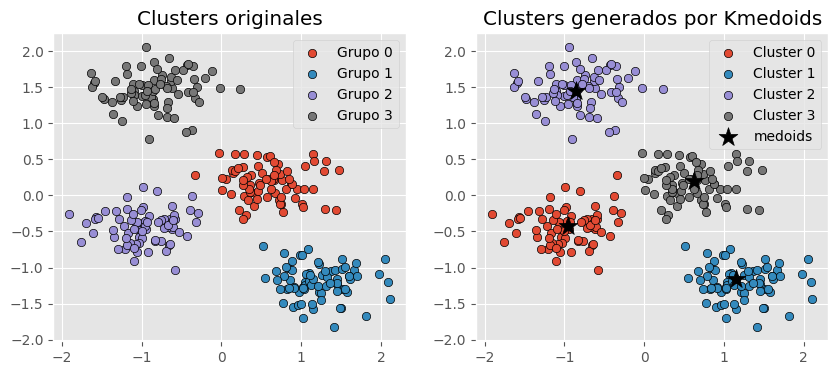

In [82]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmedoids.cluster_centers_[:, 0],
    y = modelo_kmedoids.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'medoids'
)
ax[1].set_title('Clusters generados por Kmedoids')
ax[1].legend();

# Cluster jerárquico

Usaremos el dataset USArrests que contiene estadísticas sobre arrestos por cada 100,000 residentes por asalto, asesinato y violación en cada uno de los 50 estados de EE. UU. en 1973. También se da el porcentaje de la población que vive en áreas urbanas.

In [83]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Datos

In [84]:
USArrests = sm.datasets.get_rdataset("USArrests", "datasets")
USArrests['StateAbbrv'] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC","SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

datos = USArrests.data
datos.head(4)

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5


Los escalamos

In [85]:
# Escalado de las variables
# ==============================================================================
datos_scaled = scale(X=datos, axis=0, with_mean=True, with_std=True)
datos_scaled = pd.DataFrame(datos_scaled, columns=datos.columns, index=datos.index)
datos_scaled.head(4)

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794


In [86]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

Los parámetros de la clase `sklearn.cluster.AgglomerativeClustering` que destacan:

- `n_clusters`: determina el número de clusters que se van a generar. En su lugar, su valor puede ser None si se quiere utilizar el criterio `distance_threshold` para crear los clusters o crecer todo el dendograma.
- `distance_threshold`: distancia (altura del dendograma) a partir de la cual se dejan de unir los clusters. Indicar `distance_threshold=0` para crecer todo el árbol.
- `compute_full_tree`: si se calcula la jerarquía completa de clusters. Debe ser `True` si `distance_threshold` es distinto de `None`.
- `affinity`: métrica utilizada como distancia. Puede ser: “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. Si se utiliza `linkage=“ward”`, solo se permite “euclidean”.
- `linkage: tipo de linkage utilizado. Puede ser “ward”, “complete”, “average” o “single”.

Al aplicar un hierarchical clustering aglomerativo se tiene que escoger una medida de distancia y un tipo de linkage. El concepto de linkage contempla la forma que tenemos de medir la distancia entre pares de grupos. Tenemos varias formas:
- `"ward"`. La elección de los pares de clusters que se fusionan en cada etapa del *agglomerative hierarchical clustering* se fundamenta en el valor óptimo de una función objetivo, la cual puede ser cualquier función determinada por el analista. El método de *Ward's minimum variance* es un ejemplo específico en el cual el propósito es reducir al mínimo la suma total de la varianza intra-cluster. Durante cada fase, se identifican aquellos 2 clusters cuya fusión resulta en el menor aumento de la varianza total intra-cluster. Este indicador es análogo a la métrica que se busca minimizar en el algoritmo K-means.
- `"complete"`. Se calcula la distancia entre todos los posibles pares formados por una observación del cluster A y una del cluster B. La mayor de todas ellas se selecciona como la distancia entre los dos clusters. Se trata de la medida más conservadora
- `"average"`. Se calcula la distancia entre todos los posibles pares formados por una observación del cluster A y una del cluster B. El valor promedio de todas ellas se selecciona como la distancia entre los dos clusters.
- `"single"`.Se calcula la distancia entre todos los posibles pares formados por una observación del cluster A y una del cluster B. La menor de todas ellas se selecciona como la distancia entre los dos clusters. Se trata de la medida menos conservadora

A continuación, se comparan los resultados con los linkages complete, ward y average, utilizando la distancia euclídea como métrica de similitud.

In [87]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=datos_scaled)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=datos_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=datos_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

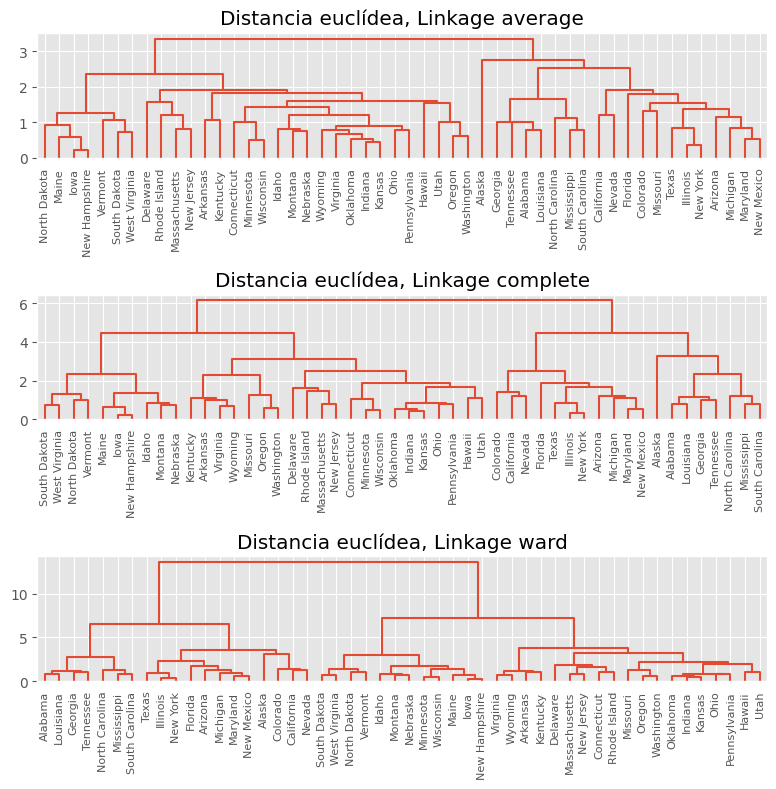

In [88]:
# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, labels=datos_scaled.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=datos_scaled.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=datos_scaled.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout();

## Número de clusters
Una forma de decidir el número de clusters, puede ser inspeccionando el dendograma y elegir la altura a la que se corta para generar los clusters. Por ejemplo, para los resultados de distancia euclidea y linkage ward, parece que una buena altura sería 5 y tendríamos 4 clusters

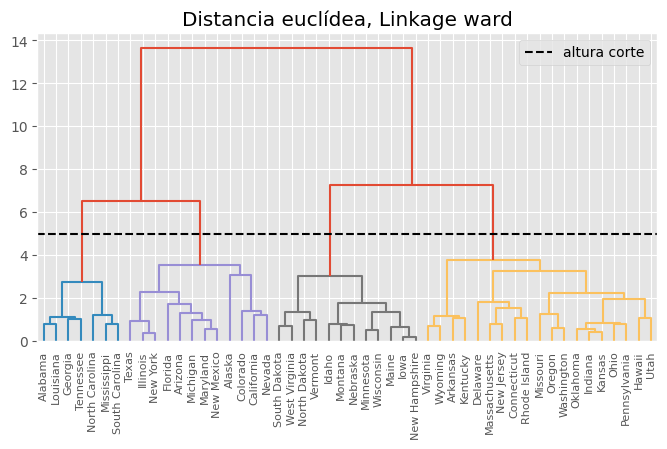

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 5
plot_dendrogram(modelo_hclust_ward, labels=datos_scaled.index, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

Otra forma de identificar potenciales valores óptimos para el número de clusters en modelos hierarchical clustering es mediante los índices silhouette.

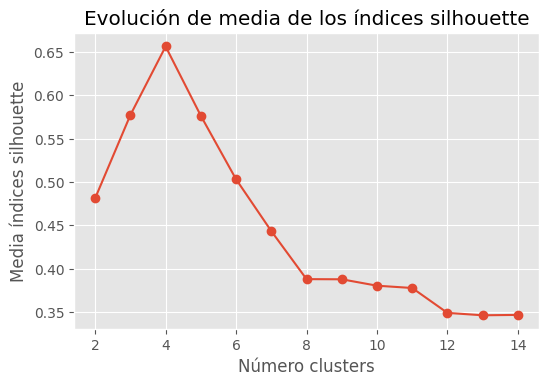

In [90]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        metric   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [91]:
# Modelo final
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'ward',
    n_clusters = 4
)
modelo_hclust_ward.fit(X=X_scaled)

AgglomerativeClustering(n_clusters=4)

# DBSCAN: Density-based spatial clustering of applications with noise


In [92]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [93]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [94]:
datos = pd.read_csv('/content/drive/MyDrive/Docencia/AprendizajeAutomatico/2022-2023/Tutoriales sklearn/DBSCAN.csv')
datos.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Docencia/AprendizajeAutomatico/2022-2023/Tutoriales sklearn/DBSCAN.csv'

Con la clase `sklearn.cluster.DBSCAN` de Scikit-Learn se pueden entrenar modelos de clustering utilizando el algoritmo DBSCAN. Entre sus parámetros destacan:
- `eps`: Distancia máxima entre dos muestras para que una se considere vecina de la otra. Define el *𝜖-neighborhood*
- `min_samples`: El número de muestras (o peso total) en un vecindario para que un punto se considere un *core point*. Esto incluye el propio punto. Si `min_samples` se establece en un valor más alto, DBSCAN encontrará conglomerados más densos, mientras que si se establece en un valor más bajo, los conglomerados encontrados serán más dispersos.
- `metric``: métrica utilizada como distancia. Puede ser: “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. Por defecto es “euclidean”.

In [95]:
# Escalado de datos
# ==============================================================================
X = datos.drop(columns='shape').to_numpy()
X_scaled = scale(X)

KeyError: "['shape'] not found in axis"

In [ ]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
#ax.legend()
ax.set_title('Nube de puntos iniciales');

In [ ]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled)

In [ ]:
# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X[labels == -1, 0],
    y = X[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [106]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 4
Número de outliers encontrados: 25


# Análisis de Componentes Principales y Clustering
Volvemos con la base de datos de USArrests.

Como hemos visto, para tener una visualización de las agrupaciones, tendríamos que reducir nuestro problema a dos o tres variables de entrada.

En problemas en los que las variables de entrada estén muy correladas, podemos pensar en reducir el número de variables utilizando PCA (Análisis de Componentes Principales)

Vamos a hacer un análisis exploratorio inicial viendo las correlaciones entre variables. esto nos dará pie a ver si podemos usar PCA más adelante.

In [96]:
USArrests = sm.datasets.get_rdataset("USArrests", "datasets")
USArrests['StateAbbrv'] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC","SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

datos = USArrests.data
datos.head(4)

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5


In [97]:
# Escalado de las variables
# ==============================================================================
datos_scaled = scale(X=datos, axis=0, with_mean=True, with_std=True)
datos_scaled_df = pd.DataFrame(datos_scaled, columns=datos.columns, index=datos.index)
datos_scaled_df.head(4)

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794


<Axes: >

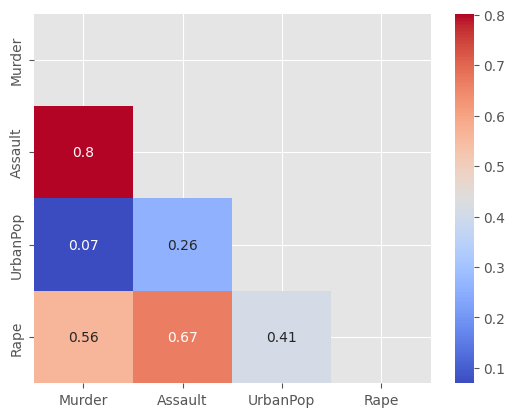

In [ ]:
estados = datos.index
corr_df = datos.corr()
etiquetas = corr_df.columns

mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="coolwarm")

Por lo que se vé, existe una correlación significativa entre algunas variables.

## PCA y visualización
En este problema tenemos cuatro variables de entrada. Para poder representar gráficamente estos datos, necesitamos que sean dos o tres variables. Por este motivo vamos a transformar los datos de entrada mediante PCA de dos dimensiones.

In [98]:
np.set_printoptions(precision=2)

X = datos_scaled_df.values.squeeze()

pca = PCA(n_components=2)

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans, columns=['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,0.985566,1.133392
1,1.950138,1.073213
2,1.763164,-0.745957
3,-0.141420,1.119797
4,2.523980,-1.542934


In [99]:
std = df_pca.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.62 0.25]
Proporción acumulada: [0.62 0.87]


Como podemos observar, con dos variables, podemos contemplar el 87% de la varianza explicada del problema. Esto nos permite dibujar las muestras en las nuevas coordenadas PC1 y PC2 como aparece a continuación.

<Axes: xlabel='PC1', ylabel='PC2'>

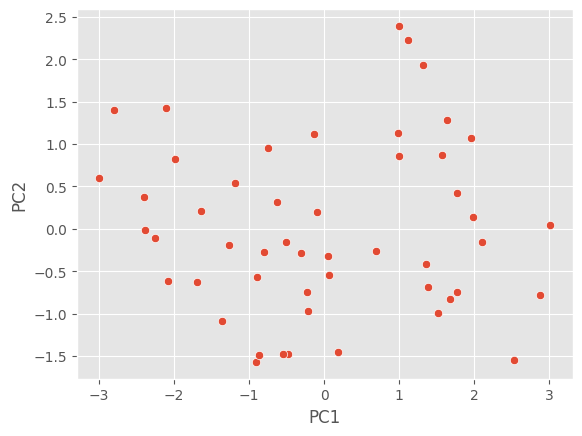

In [100]:
sns.scatterplot(data=df_pca, x="PC1", y="PC2")

Cuando se utiliza PCA, el gráfico biplot nos da información de cómo se ha realizado la transformación. Nos muestra las muestras en el espacio transformado bidimensional, junto con unos vectores en los que se representan las variables de entrada. De los vectores nos fijamos en:
* **Ángulo**: cuanto más paralelo es un vector al eje de una componente, más ha contribuido a la creación de la misma. Con ello obtienes información sobre qué variable(s) ha sido más determinante para crear cada componente, y si entre las variables (y cuales) hay correlaciones. Ángulos pequeños entre vectores representa alta correlación entre las variables implicadas (observaciones con valores altos en una de esas variables tendrá valores altos en la variable o variables correlacionadas); ángulos rectos representan falta de correlación, y ángulos opuestos representan correlación negativa (una observación con valores altos en una de las variables irá acompañado de valores bajos en la otra).
* **Longitud**: cuanto mayor la longitud de un vector relacionado con x variable, mayor variabilidad de dicha variable está contenida en la representación de las dos componentes del biplot, es decir, mejor está representada su información en el gráfico.

In [101]:
# Función para dibujar un gráfico biplot
# ==============================================================================

def biplot(scaled_data, fitted_pca, original_dim_labels, point_labels):

    pca_results = fitted_pca.transform(scaled_data)
    pca1_scores = pca_results[:,0]
    pca2_scores = pca_results[:,1]

    # plot each point in 2D post-PCA space
    plt.scatter(pca1_scores,pca2_scores)

    # label each point
    for i in range(len(pca1_scores)):
        plt.text(pca1_scores[i],pca2_scores[i], point_labels[i])

    #for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0,i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1,i]
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2 ,color = 'r',alpha = 1)
        plt.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, original_dim_labels[i], color = 'g', ha = 'center', va = 'center')





Dibujamos el gráfico biplot.

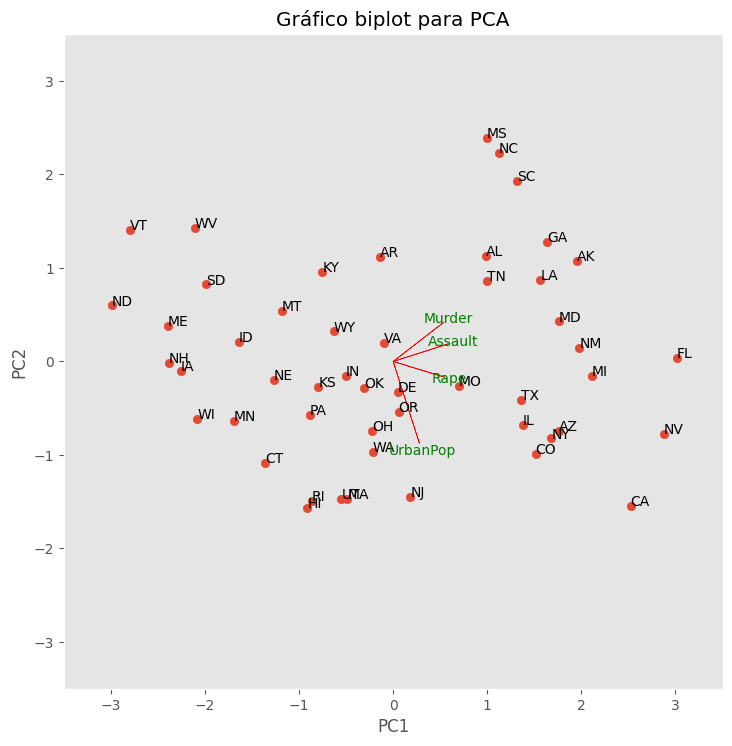

In [102]:
plt.figure(figsize=(8.5,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title("Gráfico biplot para PCA")
plt.grid()
biplot(datos_scaled, PCA().fit(datos_scaled),
       original_dim_labels=datos.columns,
       point_labels=USArrests['StateAbbrv'])

Vemos como las variables `UrbanPop` y `Murder`no tienen prácticamente correlación. Igualmente `Murder`y `Assault`sí que están correladas.

Visualmente es complicado determinar cuantas agrupaciones tenemos, usaremos el método silhouette que identifica el número óptimo de clusters.

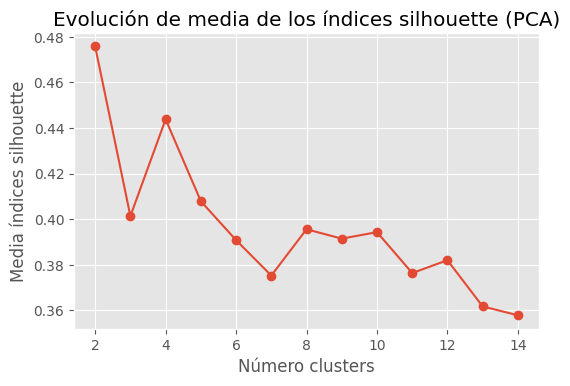

In [103]:
# Método silhouette para identificar el número óptimo de clusters (ahora con los coeficientes de la PCA)
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    cluster_labels = modelo_kmeans.fit_predict(X_trans)
    silhouette_avg = silhouette_score(X_trans, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette (PCA)")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Parece que el número ideal de clusters es de 2, pero 4 tampoco es un mal resultado. Elegimos 4 para que nos dé más juego a la hora del análisis final. Vamos a ver el resultado con un número de clusters de 4 y los métodos KMeans y DBSCAN.

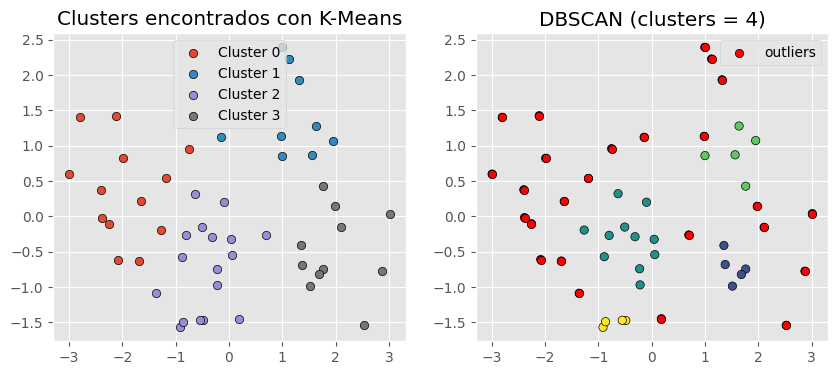

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Clustering Kmeans

y_predict_Kmeans = KMeans(n_clusters=4, n_init=25, random_state=42).fit_predict(X=X_trans)

for i in np.unique(y_predict_Kmeans):
    ax[0].scatter(
        x = X_trans[y_predict_Kmeans == i, 0],
        y = X_trans[y_predict_Kmeans == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
ax[0].set_title('Clusters encontrados con K-Means')
ax[0].legend();

# Clustering DBSCAN

modelo_dbscan = DBSCAN(eps = 0.6, min_samples  = 5, metric = 'euclidean')
y_predict = modelo_dbscan.fit(X=X_trans)

labels = modelo_dbscan.labels_
ax[1].scatter(
    x = X_trans[:, 0],
    y = X_trans[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)


# Los outliers se identifican con el label -1
ax[1].scatter(
    x = X_trans[labels == -1, 0],
    y = X_trans[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax[1].set_title(f'DBSCAN (clusters = {len(set(labels)) - (1 if -1 in labels else 0)})')
ax[1].legend();


Ahora, nuestro interés es caracterizar estos cuatros grupos que nos han salido usando alguna estadísticas descriptiva.

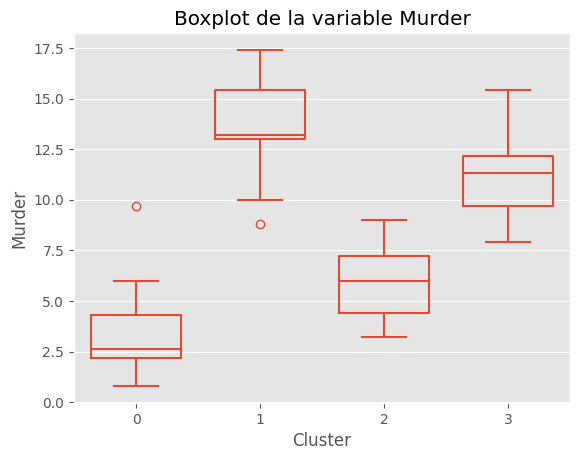

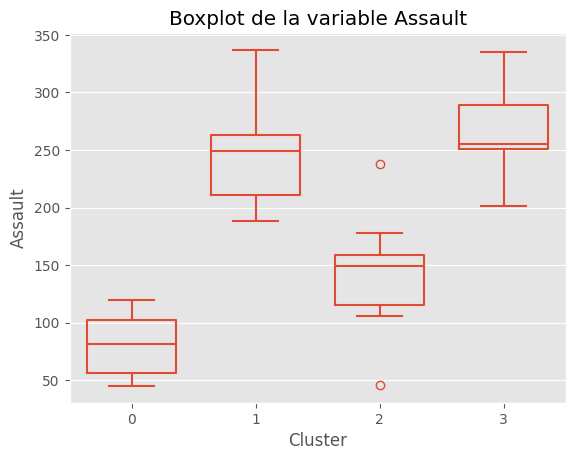

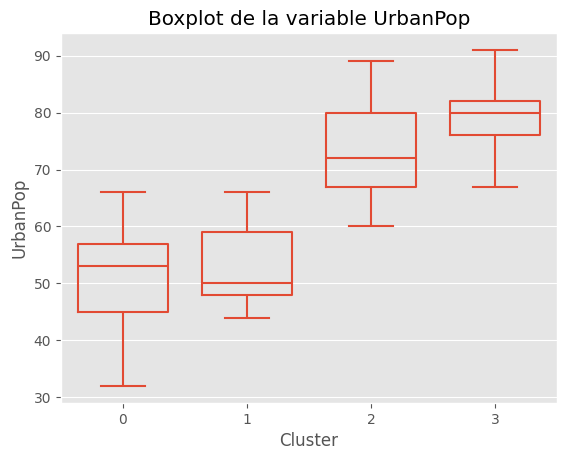

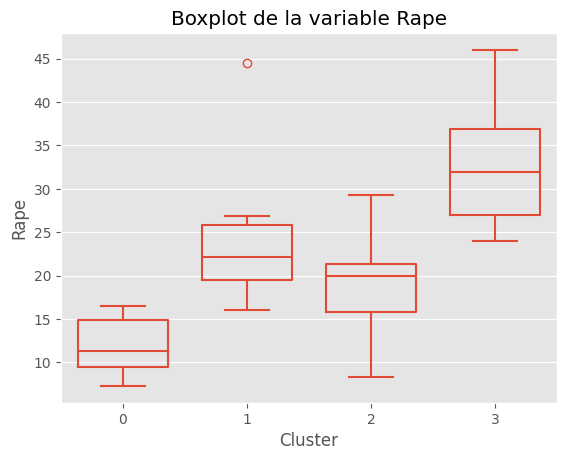

In [105]:
datos2 = datos.copy()
datos2["Cluster"]=y_predict_Kmeans

aux=datos2.columns.tolist()
aux[0:len(aux)-1]

for col in aux[0:len(aux)-1]:
    sns.boxplot(data=datos2, x="Cluster", y=col, fill=False, gap=.1)
    plt.title(f"Boxplot de la variable {col}")
    plt.show()
#    grid.map(plt.hist, cluster,color='red')

¿Podemos sacar conclusiones?

# GMMs: Gaussian mixture models

Un Gaussian Mixture model es un modelo probabilístico en el que se considera que las observaciones siguen una distribución probabilística formada por la combinación de múltiples distribuciones normales (componentes). En su aplicación al clustering, puede entenderse como una generalización de K-means con la que, en lugar de asignar cada observación a un único cluster, se obtiene una probabilidad de pertenencia a cada uno.

Para estimar los parámetros que definen la función de distribución de cada cluster (media y matriz de covarianza) se recurre al algoritmo de *Expectation-Maximization* (EM). Una vez aprendidos los parámetros, se puede calcular la probabilidad que tiene cada observación de pertenecer a cada cluster y asignarla a aquel con mayor probabilidad.

In [107]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

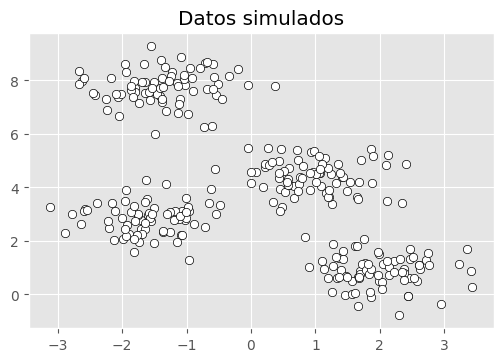

In [108]:
# Simulación de datos
# ==============================================================================
X, y = make_blobs(
        n_samples    = 300,
        n_features   = 2,
        centers      = 4,
        cluster_std  = 0.60,
        shuffle      = True,
        random_state = 0
       )

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

Con la clase `sklearn.mixture.GaussianMixture` de Scikit-Learn se pueden entrenar modelos de GMMs utilizando el algoritmo expectation-maximization (EM) . Entre sus parámetros destacan:

- `n_components`: número de componentes (en este caso clusters) que forman el modelo.

- `covariance_type`: tipo de matriz de covarianza (‘full’ (default), ‘tied’, ‘diag’, ‘spherical’).

- `max_iter`: número máximo de iteraciones permitidas.

- `random_state`: semilla para garantizar la reproducibilidad de los resultados.

In [109]:
# Modelo
# ==============================================================================
modelo_gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
modelo_gmm.fit(X=X)

GaussianMixture(n_components=4, random_state=42)

El objeto devuelto por GaussianMixture contiene entre otros datos: el peso de cada componente (cluster) en el modelo (`weights_`), su media (`means_`) y matriz de covarianza (`covariances_`).La estructura de esta última depende del tipo de matriz empleada en el ajuste del modelo (`covariance_type`).

In [110]:
# Media de cada componente
modelo_gmm.means_

array([[ 1.98,  0.87],
       [ 0.94,  4.42],
       [-1.37,  7.75],
       [-1.59,  2.82]])

In [111]:
# Matriz de covarianza de cada componente
modelo_gmm.covariances_

array([[[ 0.34, -0.03],
        [-0.03,  0.35]],

       [[ 0.38, -0.02],
        [-0.02,  0.35]],

       [[ 0.41,  0.03],
        [ 0.03,  0.38]],

       [[ 0.32,  0.01],
        [ 0.01,  0.31]]])

Una vez entrenado el modelo GMMs, se puede predecir la probabilidad que tiene cada observación de pertenecer a cada una de las componentes (clusters). Para obtener la clasificación final, se asigna a la componente con mayor probabilidad.

In [112]:
# Probabilidades
# ==============================================================================
# Cada fila es una observación y cada columna la probabilidad de pertenecer a
# cada una de las componentes.
probabilidades = modelo_gmm.predict_proba(X)
probabilidades

array([[9.72e-01, 2.59e-02, 8.05e-21, 2.38e-03],
       [7.13e-33, 7.16e-09, 1.00e+00, 2.35e-15],
       [8.78e-12, 1.00e+00, 2.05e-08, 9.13e-09],
       ...,
       [4.92e-10, 1.00e+00, 8.75e-09, 3.41e-05],
       [6.45e-30, 3.01e-06, 1.00e+00, 1.53e-18],
       [2.00e-11, 4.39e-07, 4.05e-15, 1.00e+00]])

In [113]:
# Clasificación (asignación a la componente de mayor probabilidad)
# ==============================================================================
# Cada fila es una observación y cada columna la probabilidad de pertenecer a
# cada una de las componentes.
clasificacion = modelo_gmm.predict(X)
clasificacion

array([0, 2, 1, 2, 0, 0, 3, 1, 2, 2, 3, 2, 1, 2, 0, 1, 1, 0, 3, 3, 0, 0,
       1, 3, 3, 1, 0, 1, 3, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 0, 1, 3, 1, 1,
       3, 3, 2, 3, 2, 0, 3, 0, 2, 0, 0, 3, 2, 3, 2, 0, 2, 1, 2, 3, 3, 3,
       2, 0, 2, 3, 1, 3, 2, 3, 3, 2, 3, 1, 0, 2, 0, 1, 0, 0, 2, 1, 0, 1,
       2, 2, 1, 0, 2, 3, 3, 1, 0, 0, 1, 3, 2, 0, 2, 0, 1, 0, 0, 1, 2, 1,
       3, 3, 0, 2, 0, 1, 2, 0, 0, 1, 3, 0, 3, 0, 0, 0, 0, 3, 0, 3, 2, 3,
       3, 0, 2, 3, 3, 2, 1, 2, 2, 3, 1, 3, 1, 3, 2, 1, 2, 2, 2, 1, 2, 1,
       0, 3, 2, 3, 0, 1, 2, 1, 1, 0, 1, 3, 3, 1, 0, 1, 1, 2, 0, 1, 3, 2,
       0, 0, 1, 3, 0, 1, 3, 3, 1, 1, 1, 1, 0, 2, 1, 3, 1, 1, 3, 3, 3, 1,
       3, 2, 1, 3, 0, 3, 1, 2, 3, 2, 1, 2, 1, 3, 1, 1, 2, 3, 3, 0, 0, 1,
       2, 0, 0, 3, 0, 3, 1, 2, 2, 1, 1, 2, 1, 0, 3, 1, 0, 3, 2, 3, 0, 1,
       0, 2, 2, 2, 2, 3, 3, 2, 1, 3, 0, 1, 3, 3, 3, 0, 0, 2, 1, 1, 3, 0,
       2, 3, 1, 2, 1, 0, 0, 3, 3, 1, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0,
       2, 3, 2, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 3], d

TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

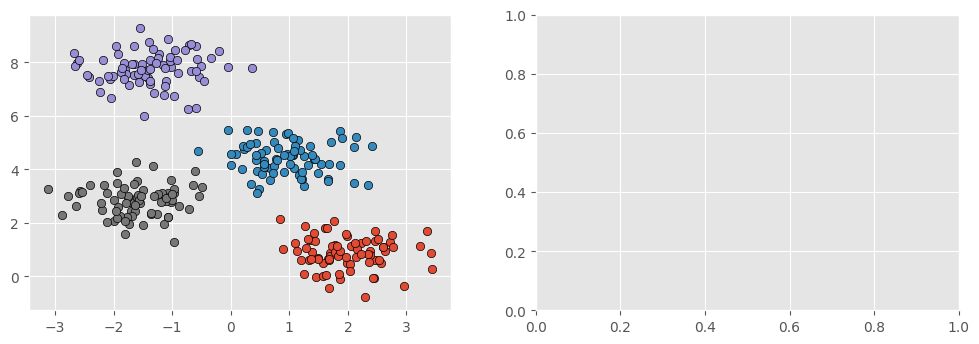

In [114]:
# Representación gráfica
# ==============================================================================
# Codigo obtenido de:
# https://github.com/amueller/COMS4995-s20/tree/master/slides/aml-14-clustering-mixture-models
def make_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)

        for i in range(1,3):
            ell = mpl.patches.Ellipse(gmm.means_[n], i*v[0], i*v[1],
                                      180 + angle, color="blue")
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.1)
            ax.add_artist(ell)


fig, axs = plt.subplots(1, 2, figsize=(12, 3.84))

# Distribución de probabilidad de cada componente
for i in np.unique(clasificacion):
    axs[0].scatter(
        x = X[clasificacion == i, 0],
        y = X[clasificacion == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

make_ellipses(modelo_gmm, ax = axs[0])
axs[0].set_title('Distribución de prob. de cada componente')
axs[0].legend()

# Distribución de probabilidad del modelo completo
xs = np.linspace(min(X[:, 0]), max(X[:, 0]), 1000)
ys = np.linspace(min(X[:, 1]), max(X[:, 1]), 1000)
xx, yy = np.meshgrid(xs, ys)
scores = modelo_gmm.score_samples(np.c_[xx.ravel(), yy.ravel()], )
axs[1].scatter(X[:, 0], X[:, 1], s=5, alpha=.6, c=plt.cm.tab10(clasificacion))
scores = np.exp(scores) # Las probabilidades están en log
axs[1].contour(
    xx, yy, scores.reshape(xx.shape),
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
axs[1].set_title('Distribución de prob. del modelo completo');

## Número de clusters
Dado que los modelos GMM son modelos probabilísticos, se puede recurrir a métricas como el Akaike information criterion (AIC) o Bayesian information criterion (BIC) para identificar cómo de bien se ajustan los datos observados a modelo creado.

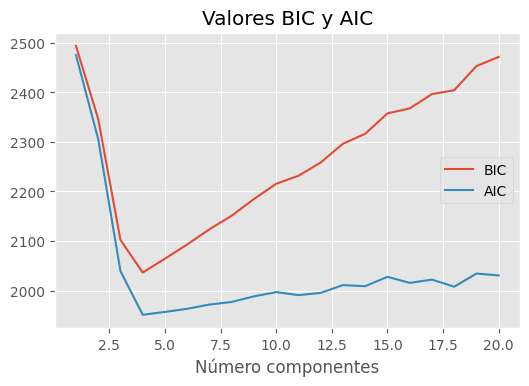

In [115]:
n_components = range(1, 21)
valores_bic = []
valores_aic = []

for i in n_components:
    modelo = GaussianMixture(n_components=i, covariance_type="full")
    modelo = modelo.fit(X)
    valores_bic.append(modelo.bic(X))
    valores_aic.append(modelo.aic(X))

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(n_components, valores_bic, label='BIC')
ax.plot(n_components, valores_aic, label='AIC')
ax.set_title("Valores BIC y AIC")
ax.set_xlabel("Número componentes")
ax.legend();

In [ ]:
print(f"Número óptimo acorde al BIC: {range(1, 21)[np.argmin(valores_bic)]}")
print(f"Número óptimo acorde al AIC: {range(1, 21)[np.argmin(valores_aic)]}")